## Persian Letters and digits classification with Keras

Auther: Parsa Mazaheri

---



### Extract dataset

In [ ]:
import os, shutil

os.chdir("/content/")
# clear previous content
def clear_workstation(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

clear_workstation('dataset')

!unzip "dataset split.zip"
!unzip "extra_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/y/152.jpg  
  inflating: dataset/train/y/153.jpg  
  inflating: dataset/train/y/154.jpg  
  inflating: dataset/train/y/155.jpg  
  inflating: dataset/train/y/156.jpg  
  inflating: dataset/train/y/157.jpg  
  inflating: dataset/train/y/158.jpg  
  inflating: dataset/train/y/159.jpg  
  inflating: dataset/train/y/16.jpg  
  inflating: dataset/train/y/160.jpg  
  inflating: dataset/train/y/161.jpg  
  inflating: dataset/train/y/162.jpg  
  inflating: dataset/train/y/163.jpg  
  inflating: dataset/train/y/164.jpg  
  inflating: dataset/train/y/165.jpg  
  inflating: dataset/train/y/166.jpg  
  inflating: dataset/train/y/167.jpg  
  inflating: dataset/train/y/168.jpg  
  inflating: dataset/train/y/169.jpg  
  inflating: dataset/train/y/17.jpg  
  inflating: dataset/train/y/170.jpg  
  inflating: dataset/train/y/171.jpg  
  inflating: dataset/train/y/172.jpg  
  inflating: dataset/train/y/173.jpg  
  inflating: da

### Import extra dataset
extra datastes images are catagorized by their names and we're going to change it to by folder

In [ ]:
# divide extra dataset data
import glob
import cv2
data_ref = {
    '_1': 'a', '_2': 'b', '_3': 't', '_4': 's_3noghte', '_5': 'j', '_6': 'h_jimi',
    '_7': 'kh', '_8': 'd', '_9': 'dz', '10': 'r', '11': 'rz', '12': 's', '13': 'sh',
    '14': 'sad', '15': 'zad', '16': 'ta', '17': 'za', '18': 'ain', '19': 'ghain',
    '20': 'f', '21': 'gh', '22': 'k', '23': 'l', '24': 'm', '25': 'n', '26': 'h',
    '27': 'v', '28': 'y',
}

files = glob.glob("extra_dataset/*")
for f in files:
    # get images char from it's name
    ch = data_ref[f.split("/")[-1][-6:-4]]
    name = f.split("/")[-1]
    I = cv2.imread(f)
    # add each char to it's char folder
    cv2.imwrite('dataset/train/' + ch + "/" + name, I)

print("imported extra dataset")

imported extra dataset


### Augment data


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'p', 't', 's_3noghte',
        'j', 'ch', 'h_jimi', 'kh', 'd', 'dz', 'r', 'rz', 'zh', 's', 'sh', 'sad', 'zad', 'ta',
        'za','ain', 'ghain', 'f', 'gh', 'k', 'g', 'l', 'm', 'n', 'v', 'h', 'y']


datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.05,
        brightness_range=(0.1,0.8),
        rotation_range=2,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=False,
        fill_mode='nearest')


def generate_data():
    for ch in chars:
        path = 'dataset/train/' + ch + '/'

        files = glob.glob(path + "*")
        if len(files) == 0:
            continue
            
        for i in range(512):
            r = random.randint(0, len(files)-1)
            seed_img = files[r]
            img = load_img(seed_img)  
            # Numpy array - shape (3, 150, 150)
            x = img_to_array(img)                    
            # Numpy array - shape (1, 3, 150, 150)
            x = x.reshape((1,) + x.shape)
            # for creating 2x images from png dataset than jpg dataset
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=path, save_prefix='', save_format='jpg'):
                if seed_img[-3:] == "png" and i == 2:
                    break
                if seed_img[-3:] == "jpg" and i == 1:
                    break
                i += 1
        print('augmented for ', ch)

generate_data()


augmented for  0
augmented for  1
augmented for  2
augmented for  3
augmented for  4
augmented for  5
augmented for  6
augmented for  7
augmented for  8
augmented for  9
augmented for  a
augmented for  b
augmented for  p
augmented for  t
augmented for  s_3noghte
augmented for  j
augmented for  ch
augmented for  h_jimi
augmented for  kh
augmented for  d
augmented for  dz
augmented for  r
augmented for  rz
augmented for  zh
augmented for  s
augmented for  sh
augmented for  sad
augmented for  zad
augmented for  ta
augmented for  za
augmented for  ain
augmented for  ghain
augmented for  f
augmented for  gh
augmented for  k
augmented for  g
augmented for  l
augmented for  m
augmented for  n
augmented for  v
augmented for  h
augmented for  y


In [ ]:
# Data count
train_data = len(glob.glob("dataset/train/*/*"))
test_data = len(glob.glob("dataset/test/*/*"))
print("train data: ", train_data)
print("test data: ", test_data)
print("total data: ", train_data + test_data)

train data:  118140
test data:  10437
total data:  128577


### Preprossing Data

In [ ]:
import os
import numpy as np
import tensorflow as tf


char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))


def preprocessing(data_type):
    data_dir = glob.glob("dataset/" + data_type + "/*")
    data_dir.sort()

    data, labels = [], []

    for char in data_dir:
        # print('extracting: ', char.split("/")[1])
        imgPaths = glob.glob(char + "/*")

        for img in imgPaths:
            image = load_img(img, target_size=(28, 28), color_mode="grayscale")
            image = img_to_array(image) 
            data.append(image)

            label = char.split("/")[2]
            label = char_to_int[label]
            labels.append(label)

    print("extracted", data_type, "count:", len(data), len(labels))

    data = np.array(data, dtype=np.float) 
    labels = np.array(labels)
    return data, labels


data, labels = preprocessing('train')
test_data, test_labels = preprocessing('test')


extracted train count: 118140 118140
extracted test count: 10437 10437


In [ ]:
# test
i = 72636
from google.colab.patches import cv2_imshow
cv2_imshow(data[i])
print(int_to_char[labels[i]] )


m


### Building Model

In [ ]:
from keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint


num_classes = len(chars)

    
def build_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

model = build_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_120 (Bat (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_121 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_122 (Bat (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_52 (Dropout)         (None, 12, 12, 32)      

### Train the model

In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

checkpoint = ModelCheckpoint(filepath="model.h5",
                             monitor="val_acc",
                             verbose=1,
                             save_best_only=True)
# TRAIN NETWORKS
epochs = 10


train_x, val_x, train_y, val_y = train_test_split(data, labels, test_size = 0.1)

train_log = model.fit_generator(datagen.flow(train_x,train_y, batch_size=64),
    epochs = epochs, steps_per_epoch = len(train_x)//64,  
    validation_data = [val_x,val_y], callbacks=[annealer, checkpoint], verbose=1)
    

Epoch 1/10
1661/1661 [==============================] - 494s 297ms/step - loss: 2.2773 - acc: 0.3532 - val_loss: 0.8136 - val_acc: 0.7211

Epoch 00001: val_acc improved from -inf to 0.72109, saving model to model.h5
Epoch 2/10
1661/1661 [==============================] - 500s 301ms/step - loss: 1.0695 - acc: 0.6491 - val_loss: 0.6100 - val_acc: 0.7980

Epoch 00002: val_acc improved from 0.72109 to 0.79795, saving model to model.h5
Epoch 3/10
1661/1661 [==============================] - 497s 299ms/step - loss: 0.8356 - acc: 0.7231 - val_loss: 0.4048 - val_acc: 0.8577

Epoch 00003: val_acc improved from 0.79795 to 0.85771, saving model to model.h5
Epoch 4/10
1661/1661 [==============================] - 494s 298ms/step - loss: 0.7371 - acc: 0.7551 - val_loss: 0.3830 - val_acc: 0.8685

Epoch 00004: val_acc improved from 0.85771 to 0.86846, saving model to model.h5
Epoch 5/10
1661/1661 [==============================] - 494s 298ms/step - loss: 0.6694 - acc: 0.7773 - val_loss: 0.3234 - val_a

### Evaluate

In [ ]:

results = model.predict(test_data)
results = np.argmax(results,axis = 1)

c = 0
for i in range(len(results)):
    if test_labels[i] == results[i]:
        c += 1
print("Accuracy: {:.2f}%".format(100*c / len(results)))

Accuracy: 94.55%


### Ploting Training Log

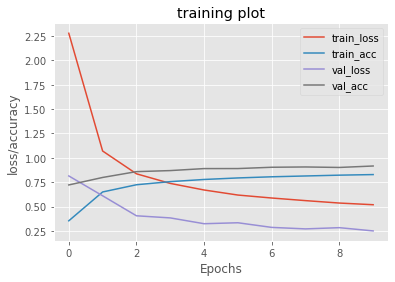

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(epochs), train_log.history["loss"], label="train_loss")
plt.plot(np.arange(epochs), train_log.history["acc"], label="train_acc")
plt.plot(np.arange(epochs), train_log.history["val_loss"], label="val_loss")
plt.plot(np.arange(epochs), train_log.history["val_acc"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.title("training plot")
plt.legend(loc="upper right")
plt.savefig("training_plot.png")